#Prework

## Operative System

In [1]:
!rm -R sample_data
!cat /etc/*release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


## Instalation

In [2]:
# Installing wget
!apt-get install wget
# Installing eagleSqlTools
!pip install eagleSqlTools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## Libreries

In [3]:
import os                                                                       # Librería para trabajar con el sistema operativo
import h5py                                                                     # Librería para trabajar con archivos hdf5
import gc                                                                       # Librería de limpiea de datos
import numpy as np                                                              # Librería estandar para tratado de datos
import eagleSqlTools as eagle                                                   # Librería con herramientas de las simulaciones de EAGLE
import matplotlib.pyplot as plt                                                 # Librería para visualizar gráficas.

list_sim = ["RefL0012N0188", "RefL0025N0376"]
sim = list_sim[0]

## Snapshots Download

In [4]:
def load_snapshot(simulation, snapnum):                                         # Función para cargar los datos de cada snapshot
  print(snapnum)
  # input_text
  url = "'http://dataweb.cosma.dur.ac.uk:8080/eagle-snapshots//download?run=%s&snapnum=%i'"%(simulation, snapnum)
  
  # extension final del path tar
  if len(str(snapnum)) == 1:          
    tar = "%s_snap_00%i.tar"%(simulation, snapnum)
  elif len(str(snapnum)) == 2: 
    tar = "%s_snap_0%i.tar"%(simulation, snapnum)
  else:
    tar = "%s_snap_%i.tar"%(simulation, snapnum)

  # path del tar
  path = "/content/%s"%(tar)

  # Download
  !wget --user=wvd747 --password=CGQ269nm --content-disposition {url}
  # Discompression
  !tar -xf {path}
  # Remove tar file
  !rm -R {tar}

# Carga de los snapshot 0 y 28
for i in [0, 28]:
  load_snapshot(simulation=sim, snapnum=i) 

0
--2021-05-12 11:47:10--  http://dataweb.cosma.dur.ac.uk:8080/eagle-snapshots//download?run=RefL0012N0188&snapnum=0
Resolving dataweb.cosma.dur.ac.uk (dataweb.cosma.dur.ac.uk)... 193.60.196.24
Connecting to dataweb.cosma.dur.ac.uk (dataweb.cosma.dur.ac.uk)|193.60.196.24|:8080... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Eagle Database Authentication"
Reusing existing connection to dataweb.cosma.dur.ac.uk:8080.
HTTP request sent, awaiting response... 200 OK
Length: 565872640 (540M) [application/octet-stream]
Saving to: ‘RefL0012N0188_snap_000.tar’

RefL0012N0188_snap_ 100%[===================>] 539.66M  27.5MB/s    in 21s     

2021-05-12 11:47:33 (25.8 MB/s) - ‘RefL0012N0188_snap_000.tar’ saved [565872640/565872640]

28
--2021-05-12 11:47:35--  http://dataweb.cosma.dur.ac.uk:8080/eagle-snapshots//download?run=RefL0012N0188&snapnum=28
Resolving dataweb.cosma.dur.ac.uk (dataweb.cosma.dur.ac.uk)... 193.60.196.24
Connecting t

# Class Data_snapnum

In [5]:
# Clase para obtener los datos de un snapshot de una simulation
class Data_snapnum():
  def __init__(self, simulation, snapnum, path,
               user_name="wvd747", password="CGQ269nm"):
    """
      Para cargar la clase se pide:
        simulation         : La simulación de donde se va a obtener la información 
        snapnum            : El número relacionado al snapshot de dicha simulación 
        path               : Path donde se encuentran los datos del snapshot si no se han 
                             descargado todavía
        user_name, password: El usuario y contraseña de alguna cuenta EAGLE para 
                             poder descargar los datos
    """
    # Se guarda los datos de entrada en el objeto.
    self.user    = {'username':user_name, 'password': password}                 # EAGLE User information.
    self.sim     = simulation                                                   # Nombre de la simulación (e.g. RefL0012N0188).
    self.snapnum = snapnum                                                      # Número del snapshot (0, ..., 28).
    self.path    = path                                                         # Path de la base de datos.
    self.subpath = "snap"+self.path[len("/content/%s/snapshot"%(self.sim)):]    # Subpath dentro del path que se utiliza para obtener ciertos datos.

    # Se carga ciertas constantes interesantes (a, h y m_DM)
    f = h5py.File('%s/%s.%i.hdf5'%(self.path, self.subpath, 0), 'r')            # Se carga el archivo para obtener las constantes
    self.a = f['Header'].attrs.get('Time')                                      # Scale factor
    self.h = f['Header'].attrs.get('HubbleParam')                               # Hubble constan (H_0/100km s^{-1} Mpc^{-1})

    cgs  = f['PartType%i/%s'%(0, 'Mass')].attrs.get('CGSConversionFactor')      
    aexp = f['PartType%i/%s'%(0, 'Mass')].attrs.get('aexp-scale-exponent')
    hexp = f['PartType%i/%s'%(0, 'Mass')].attrs.get('h-scale-exponent')
    self.m_DM = f['Header'].attrs.get('MassTable')[1]*self.a**(aexp)*self.h**(hexp)*cgs # Masa de la materia oscura en gramos
    del(cgs, aexp, hexp)
    gc.collect()

    self.rho_c = 30000/((3.086e+19)**2*6.6743e-8*8*np.pi)*(self.h)**2           # densidad crítica (g/cm^3)
    Omega_matter = f['Header'].attrs.get('Omega0')                              # Scale factor
    self.rho_matter_z0 = self.rho_c*Omega_matter                                # density at snapshot 28, redshift = 0
    self.rho_matter = self.rho_matter_z0*self.a**(-3)                           # density at this snapshot.

    cgs  = f['PartType%i/%s'%(0, 'Coordinates')].attrs.get('CGSConversionFactor')      
    aexp = f['PartType%i/%s'%(0, 'Coordinates')].attrs.get('aexp-scale-exponent')
    hexp = f['PartType%i/%s'%(0, 'Coordinates')].attrs.get('h-scale-exponent')

    self.boxsize = f['Header'].attrs.get('BoxSize')*self.a**(aexp)*self.h**(hexp)*cgs # Tamaño del universo en centimetros

    del(f, cgs, aexp, hexp, Omega_matter)                                       # Eliminación de las variables temporales
    gc.collect()                                                                # Confirmación de eliminación


    if self.snapnum != 0:
      self.load_catalogue()


  def load_catalogue(self):                                                     # Función para cargar ciertos datos de las galaxias.
    """
      Función que permite cargar las distintas galaxias con ciertas propiedades 
      comop pueden ser sus GroupNumber y SubGroupNumber. 

      Esto vale para todo aquel que sea distinto de snapnum 0, porque es a partir
      de ese que se registran los GroupNumber y SubGroupnumber

      Query information:
        Snapnum: Snapshot's number
        Galaxy ID: Number for each galaxy at snapnum number
        GroupNumber: Número para diferenciar regiones de la simulación
        SubGroupNumber: Número para diferencias subregiones
        KappaCoRot: Disc parameter (if KappaCoRot > 0.4 -> Galaxy Disc-like)
    """
    con = eagle.connect(user     = self.user['username'], 
                        password = self.user['password'])                       # Connection with the database
    
    Query = "SELECT \
                    MK.GalaxyID, \
                    SH.GroupNumber,\
                    SH.SubGroupNumber,\
                    MK.KappaCoRot \
              FROM \
                    %s_SubHalo AS SH, \
                    %s_MorphoKinem AS MK \
              WHERE \
                    SH.GalaxyID = MK.GalaxyID AND \
                    SH.SnapNum = %i \
              ORDER BY \
                    SH.GalaxyID"%(self.sim, self.sim, self.snapnum)             # Query

    self.catalogue = eagle.execute_query(con , Query)                           # Catalogue variable

    del(con, Query)                                                             # Eliminación de las variables temporales
    gc.collect()                                                                # Confirmación de eliminación

  
  def read_dataset(self, itype, att, nfiles=16):                                # Function to read the data  
    """
      itype es el tipo de partículas del que se quiere conocer la información
          PartType0 --> Gas particle data
          PartType1 --> Dark matter particle data
          PartType4 --> Star particle data
          PartType5 --> Black hole particle data
      att es el atributo que se quiere conocer de esa partícula.
    """

    data = []                                                                   # Output array

    # Caso de la materia oscura
    if itype==1 and att=='Mass':
      f = h5py.File('%s/%s.%i.hdf5'%(self.path, self.subpath, 0), 'r')          # Carga del archivo para conover el número de particulas de materia oscura, coincide con el número de partículas del principio ('RefL0012N0188' --> 188**3 partículas)
      n_particles = f['Header'].attrs.get('NumPart_Total')[1]                   # número de particulas
      
      data = np.ones(n_particles)*self.m_DM                                     # Array con todo los valores de las masas de todas estas partículas
      data.dtype = [('Mass', data.dtype)]                                       # Se añade la etiqueta Mass 
      del(f, n_particles)                                              
      return data

    # Resto de casos
    else:
      try:                                                                      # Existen fallos cuando no hay del itype especificado, así que se añade un try, except
        for i in range(nfiles):                                                 # Loop over each file and extract the data.
        
          f = h5py.File('%s/%s.%i.hdf5'%(self.path, self.subpath, i), 'r')      # Load the i-st File
          tmp = f['PartType%i/%s'%(itype, att)][...]                            # The att in that File
          data.append(tmp)

          """
          In the paper (arXiv: 1706.09899, part 4.1) repeat these calcs for each
          nfile (i.e. i value) but they didn't save in any variable, they overwrite all
          these variables, so it's fast if we do only in the last one, or first or whatever.

          I choose the last one.
          """
          if i == nfiles-1: 
            # Conversion factors
            cgs  = f['PartType%i/%s'%(itype, att)].attrs.get('CGSConversionFactor')
            aexp = f['PartType%i/%s'%(itype, att)].attrs.get('aexp-scale-exponent')
            hexp = f['PartType%i/%s'%(itype, att)].attrs.get('h-scale-exponent')

          f.close()
          del(f)
          gc.collect()
        
        # Combine to a single array.
        if len(tmp.shape) > 1:
          data = np.vstack(data)
        else: 
          data = np.concatenate(data)

        if att != 'ParticleIDs' and data.dtype != np.int32 and data.dtype != np.int64:                   # Convert to physical.
          data = np.multiply(data, cgs*self.a**aexp * self.h**hexp, dtype='f8')

        del(cgs, aexp, hexp, tmp)
        gc.collect()

      except KeyError:                                                          # Por si no existen partículas de ese itype en este snapshot
        if att == 'Coordinates':
          data = np.ones(3)*np.nan

        else:
          data = np.array([np.nan], dtype=data.dtype)
      
      finally:
        # dtypes
        if att == 'Coordinates':                                                # Caso especial de Coordinates
          data.dtype = [('Coordinates_%i'%(i), data.dtype) for i in [0, 1, 2]]

        else:
          data.dtype = [(att, data.dtype)]

        return data

  def periocidity(self, array, point, center=False):
    if point.dtype == np.dtype([('ParticleIDs', '<u8'), ('Coordinates_0', '<f8'), 
                                ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8'), 
                                ('Mass', '<f8'), ('itype', 'i1')]):
      for i in [0, 1, 2]:
        i_point = point['Coordinates_%i'%(i)]
        array['Coordinates_%i'%(i)] -= i_point
        mask = array['Coordinates_%i'%(i)] > self.boxsize/2
        mask = mask.astype(np.int)*self.boxsize
        array['Coordinates_%i'%(i)] -= mask
        del(mask)
        gc.collect()

        mask = array['Coordinates_%i'%(i)] < -self.boxsize/2
        mask = mask.astype(np.int)*self.boxsize
        array['Coordinates_%i'%(i)] += mask
        if not(center): 
          array['Coordinates_%i'%(i)] += i_point
        del(i_point, mask)
        gc.collect()

      return array

    else:
      for i in [0, 1, 2]:
        array['Coordinates_%i'%(i)] -= point[i]

        mask = array['Coordinates_%i'%(i)] > self.boxsize/2
        mask = mask.astype(np.int)*self.boxsize
        array['Coordinates_%i'%(i)] -= mask
        
        del(mask)
        gc.collect()

        mask = array['Coordinates_%i'%(i)] < -self.boxsize/2
        mask = mask.astype(np.int)*self.boxsize
        array['Coordinates_%i'%(i)] += mask

        if not(center):
          array += point[i]
        
        del(mask)
        gc.collect()

      return array

  def particles_prop(self, itype, gn=None, sgn=None):                           # Función para obtener los datos de las partículas de un cierto sector
    """
      A galaxy is defined by its GroupNumber and SubGroupNumber,
      extract the coordinates of all particles of a selected type.
      Coordinates are then wrapped around the centre to account for periodicity.
        * simulation, e.g. RefL0012N0188
        * snapnum, snapshot number (0, ..., 28)
        * itype is the i-st PartType:
            PartType0 --> Gas particle data
            PartType1 --> Dark matter particle data
            PartType4 --> Star particle data
            PartType5 --> Black hole particle data
        * gn is de GroupNumber:
            Tag with a maximum of 2**30 particles and runs 1 to N 
        * sgn is the SubGroupNumber:

        * centre is the centre of the preiodicity
    """
    # Carga de todas las propiedades
    ParticleIDs = self.read_dataset(itype=itype, att='ParticleIDs')             # IDs de las particles
    Coordinates = self.read_dataset(itype=itype, att='Coordinates')             # Coordinates de las particles
    Mass        = self.read_dataset(itype=itype, att='Mass')                    # Masa de las particles
    
    # Se crea el recipiente, el data_dtype es el de la suma de las propiedades
    data_dtype = np.dtype(ParticleIDs.dtype.descr + Coordinates.dtype.descr +  Mass.dtype.descr + [('itype', np.int8)])
    data = np.zeros_like(ParticleIDs, dtype = data_dtype)

    # Se añaden todos los elementos
    data['itype'] = np.ones(len(ParticleIDs))*itype                             # Itype

    data['ParticleIDs'] = ParticleIDs['ParticleIDs']                          # ParticleIDs
    del(ParticleIDs)
    gc.collect()

    data['Coordinates_0'] = Coordinates['Coordinates_0'].reshape(len(Coordinates)) # Coordinada eje 0
    data['Coordinates_1'] = Coordinates['Coordinates_1'].reshape(len(Coordinates)) # Coordinada eje 1
    data['Coordinates_2'] = Coordinates['Coordinates_2'].reshape(len(Coordinates)) # Coordinada eje 2
    del(Coordinates)
    gc.collect()

    data['Mass']  = Mass['Mass']                                                # Masa
    del(Mass)
    gc.collect()

    if gn != None and sgn != None and self.snapnum != 0:                        # Existe la posibilidad de añadir una máscara sobre el GroupNumber y SubGroupNumber, pero no sé si será necesario

      gns  = self.read_dataset(itype, 'GroupNumber')['GroupNumber']
      sgns = self.read_dataset(itype, 'SubGroupNumber')['SubGroupNumber']
      mask = np.logical_and(gns == gn, sgns == sgn)
      del(gns, sgns)
      gc.collect()

      data = data[mask]
      del(mask)
      gc.collect()

      data.dtype = data_dtype          

    return data

  def looking_particles(self, ID_in):                                           # Función para encontrar las posiciones de las partículas en este snapshot
    # Carga de todas las id con sus partículas
    data_id = []
    data_co = []
    for itype in [0, 1, 4, 5]:
      data_id.append(self.read_dataset(itype=itype, att='ParticleIDs'))
      data_co.append(self.read_dataset(itype=itype, att='Coordinates'))

    ParticleIDs = np.concatenate(tuple(data_id))                                # IDs de las particles
    del(data_id)
    gc.collect()

    Coordinates = np.vstack(data_co)
    del(data_co)                                            # Coordinates de las p
    gc.collect()

    # Comparación de cuales son las partículas buscadas
    mask = np.in1d(ar1=ParticleIDs['ParticleIDs'], ar2=ID_in)
    del(ParticleIDs)
    gc.collect()
    # Aplicación de la máscara a sus coordenadas
    data = np.array(Coordinates[mask], dtype=Coordinates.dtype)
    del(mask)
    gc.collect()

    return data


# Test

## Load_snapshot()

In [6]:
Data_0 = Data_snapnum(simulation=sim, snapnum=0,                       
                      path='/content/%s/snapshot_000_z020p000'%(sim))    # Carga de los datos para snapshot 0
Data_28 = Data_snapnum(simulation=sim, snapnum=28, 
                      path='/content/%s/snapshot_028_z000p000'%(sim))    # Carga de los datos para snapshot 1

## Catalogue

In [7]:
Data_28.catalogue

array([( 3748,  1,  0, 0.12834346), (12410,  1,  1, 0.16467976),
       (12902,  1,  7, 0.19522879), (13266,  1, 10, 0.17735858),
       (20455,  2,  0, 0.14587908), (30494,  3,  0, 0.19881213),
       (32520,  3,  1, 0.55815501), (36282,  3,  2, 0.22782111),
       (37445,  4,  0, 0.63226682), (40124,  5,  0, 0.31661667),
       (41505,  5,  3, 0.23064903), (43163,  6,  0, 0.65111547),
       (44063,  6,  1, 0.21611816), (44545,  7,  0, 0.29914998),
       (46366,  8,  0, 0.17298878), (47385,  8,  1, 0.16502023),
       (48383,  9,  0, 0.27209243), (49986, 10,  0, 0.3508955 ),
       (50969, 10,  1, 0.42902912), (51640, 11,  0, 0.43823871),
       (52782, 12,  0, 0.20239774), (53904, 13,  0, 0.17692318),
       (55343, 14,  0, 0.4676442 ), (56522, 15,  0, 0.32593988),
       (57647, 16,  0, 0.48309825), (58574, 17,  0, 0.40798875),
       (59467, 18,  0, 0.15350349), (60184, 19,  0, 0.18740352),
       (61119, 20,  0, 0.18707812), (61831, 21,  0, 0.27006257),
       (62355, 22,  0, 0.

## Read_dataset()

Caso genérico:

In [8]:
example_1_1 = Data_28.read_dataset(itype= 4, att= 'ParticleIDs')
example_1_1

array([(3045808355245,), (3475194347521,), (3473835528119,), ...,
       (5306660329717,), (4589055311329,), (4589128448909,)],
      dtype=[('ParticleIDs', '<u8')])

In [9]:
del(example_1_1)
gc.collect()

52

Caso de masa oscura:

In [10]:
example_1_2 = Data_28.read_dataset(itype= 1, att= 'Mass')
example_1_2

array([(1.92834471e+40,), (1.92834471e+40,), (1.92834471e+40,), ...,
       (1.92834471e+40,), (1.92834471e+40,), (1.92834471e+40,)],
      dtype=[('Mass', '<f8')])

In [11]:
del(example_1_2)
gc.collect()

100

Caso de coordenadas:

In [12]:
example_1_3 = Data_28.read_dataset(itype= 1, att= 'Coordinates')
example_1_3

array([[(2.62837575e+23, 1.29356495e+22, 1.48563352e+23)],
       [(4.76550546e+23, 5.78030079e+23, 3.75901313e+23)],
       [(4.92908864e+23, 5.75841246e+23, 7.32162146e+23)],
       ...,
       [(9.99485161e+23, 5.48788822e+23, 3.76254415e+25)],
       [(6.19939777e+23, 3.03654120e+23, 3.79628108e+25)],
       [(4.83553953e+23, 1.87625692e+23, 3.78005871e+25)]],
      dtype=[('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8')])

In [13]:
del(example_1_3)
gc.collect()

50

Caso de KeyError:

In [14]:
example_1_4 = Data_0.read_dataset(itype=5, att='Coordinates')
example_1_4

array([(nan, nan, nan)],
      dtype=[('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8')])

In [15]:
del(example_1_4)
gc.collect()

100

## Particles_prop()

Prueba con solo el itype

In [16]:
example_2_1 = Data_28.particles_prop(itype=1)
print('Shape: ', example_2_1.shape); example_2_1

Shape:  (6644672,)


array([(5674455409232, 2.62837575e+23, 1.29356495e+22, 1.48563352e+23, 1.92834471e+40, 1),
       (5674456065614, 4.76550546e+23, 5.78030079e+23, 3.75901313e+23, 1.92834471e+40, 1),
       (5672847481138, 4.92908864e+23, 5.75841246e+23, 7.32162146e+23, 1.92834471e+40, 1),
       ...,
       (5674711574256, 9.99485161e+23, 5.48788822e+23, 3.76254415e+25, 1.92834471e+40, 1),
       (5674717300250, 6.19939777e+23, 3.03654120e+23, 3.79628108e+25, 1.92834471e+40, 1),
       (5674722185852, 4.83553953e+23, 1.87625692e+23, 3.78005871e+25, 1.92834471e+40, 1)],
      dtype=[('ParticleIDs', '<u8'), ('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8'), ('Mass', '<f8'), ('itype', 'i1')])

Prueba con mask

In [17]:
example_2_2 = Data_28.particles_prop(itype=1, gn=1, sgn=0)
print('Shape: ', example_2_2.shape); example_2_2

Shape:  (672590,)


array([(4362470405692, 5.69908377e+23, 1.50680633e+25, 4.84469570e+24, 1.92834471e+40, 1),
       (2846156962912, 5.96238468e+23, 1.50807317e+25, 4.83828968e+24, 1.92834471e+40, 1),
       (4364013916796, 5.99646577e+23, 1.50889358e+25, 4.87204042e+24, 1.92834471e+40, 1),
       ...,
       (5210700004152, 3.84508061e+25, 1.34488269e+25, 2.40504165e+24, 1.92834471e+40, 1),
       (5047438933654, 3.85032261e+25, 1.34855477e+25, 2.40563420e+24, 1.92834471e+40, 1),
       (5038841732030, 3.85002617e+25, 1.34868831e+25, 2.39767829e+24, 1.92834471e+40, 1)],
      dtype=[('ParticleIDs', '<u8'), ('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8'), ('Mass', '<f8'), ('itype', 'i1')])

Concatenación:


In [18]:
example_2_3 = np.concatenate((example_2_1, example_2_2))
example_2_3.shape[0] == example_2_1.shape[0] + example_2_2.shape[0]

True

In [19]:
del(example_2_3, example_2_2, example_2_1)
gc.collect()

100

Otro ejemplo

In [20]:
data = [Data_28.particles_prop(itype= itype, gn = 1, sgn=0) for itype in [0, 1, 4, 5]]
example_2_4 = np.concatenate(tuple(data))
example_2_4

array([(  45729455379, 5.20927678e+23, 1.50766577e+25, 4.87959698e+24, 3.61510416e+39, 0),
       (3239907596519, 6.56652177e+23, 1.50858766e+25, 4.87388663e+24, 3.60121270e+39, 0),
       (4207766138265, 6.76984607e+23, 1.49995899e+25, 4.84156277e+24, 3.62185258e+39, 0),
       ...,
       (  25199429207, 3.64267865e+25, 1.44153169e+25, 4.70523257e+24, 3.60364710e+39, 5),
       ( 961155444115, 3.71238291e+25, 1.32036617e+25, 4.45646135e+24, 3.59603297e+39, 5),
       (3239481148693, 3.60837593e+25, 1.30376610e+25, 4.04472281e+24, 3.63959809e+39, 5)],
      dtype=[('ParticleIDs', '<u8'), ('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8'), ('Mass', '<f8'), ('itype', 'i1')])

In [21]:
del(data)
gc.collect()

50

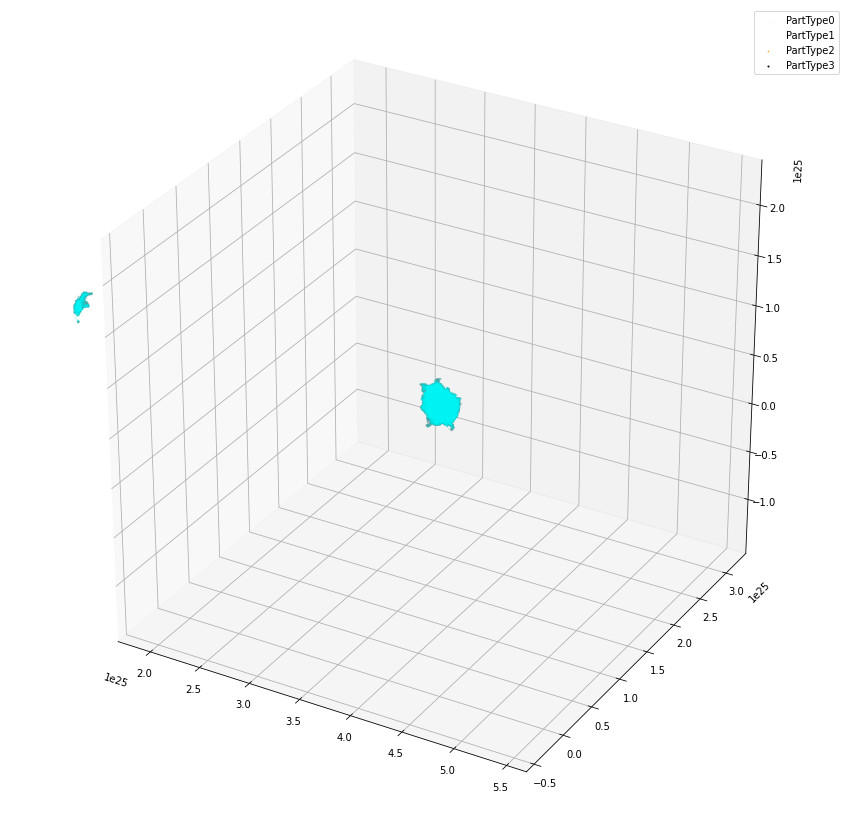

In [22]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

alpha = [0.1, 0.1, 0.5, 1]
color = ['cyan', 'grey', 'darkorange', 'black']
s = [0.2, 0.1, 1, 1]

for itype, i in zip([0, 1, 4, 5], [0, 1, 2, 3]):

  mask = example_2_4['itype'] == itype
  ax.scatter(xs= example_2_4['Coordinates_0'][mask], 
             ys= example_2_4['Coordinates_1'][mask], 
             zs= example_2_4['Coordinates_2'][mask], 
             s= s[i], label='PartType%i'%i, alpha=alpha[i], color=color[i])
  
  del(mask)
  gc.collect()
del(alpha, color, s)
gc.collect()

max_distancia = max([max(example_2_4['Coordinates_%i'%(i)])-min(example_2_4['Coordinates_%i'%(i)]) for i in [0, 1, 2]])/2
media = [np.mean(example_2_4['Coordinates_%i'%(i)]) for i in [0, 1, 2]]

ax.set_xlim(media[0]-max_distancia, media[0]+max_distancia)
ax.set_ylim(media[1]-max_distancia, media[1]+max_distancia)
ax.set_zlim(media[2]-max_distancia, media[2]+max_distancia)
  
plt.legend()
plt.show()

In [23]:
del( max_distancia, media)
del(fig, ax)
gc.collect()

3780

## Periodicity

In [24]:
example_2_4_p = Data_28.periocidity(example_2_4, example_2_4[0]); example_2_4_p

array([(  45729455379,  5.20927678e+23, 1.50766577e+25, 4.87959698e+24, 3.61510416e+39, 0),
       (3239907596519,  6.56652177e+23, 1.50858766e+25, 4.87388663e+24, 3.60121270e+39, 0),
       (4207766138265,  6.76984607e+23, 1.49995899e+25, 4.84156277e+24, 3.62185258e+39, 0),
       ...,
       (  25199429207, -2.14418849e+24, 1.44153169e+25, 4.70523257e+24, 3.60364710e+39, 5),
       ( 961155444115, -1.44714589e+24, 1.32036617e+25, 4.45646135e+24, 3.59603297e+39, 5),
       (3239481148693, -2.48721568e+24, 1.30376610e+25, 4.04472281e+24, 3.63959809e+39, 5)],
      dtype=[('ParticleIDs', '<u8'), ('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8'), ('Mass', '<f8'), ('itype', 'i1')])

In [25]:
del(example_2_4)
gc.collect()

50

visualizacion

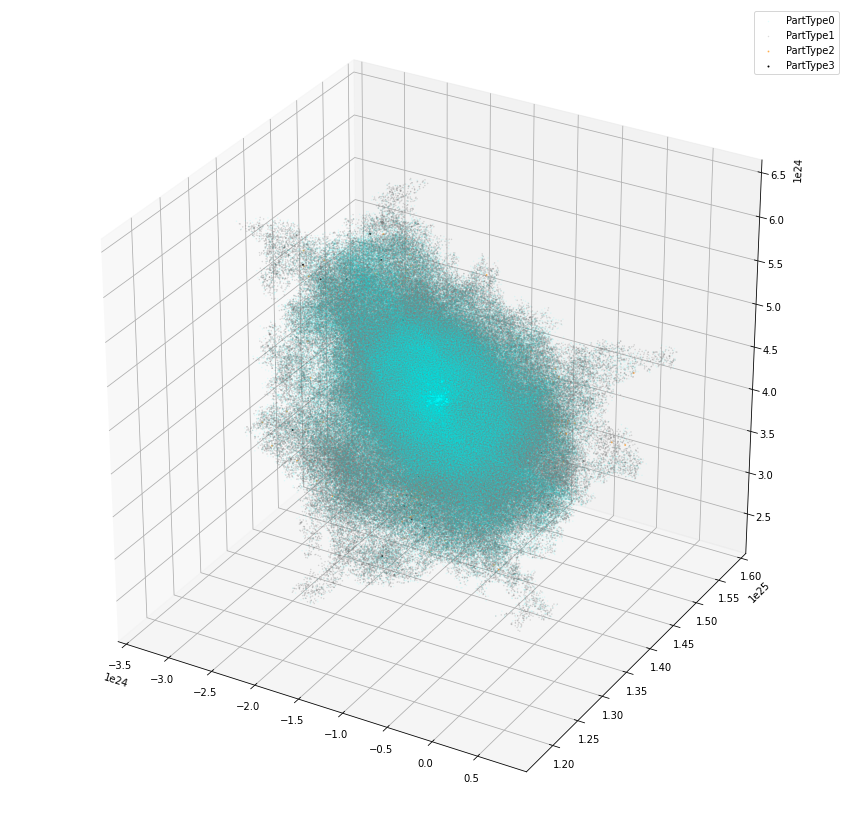

In [26]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

alpha = [0.1, 0.3, 0.5, 1]
color = ['cyan', 'grey', 'darkorange', 'black']
s = [0.2, 0.2, 1, 1]

for itype, i in zip([0, 1, 4, 5], [0, 1, 2, 3]):

  mask = example_2_4_p['itype'] == itype
  ax.scatter(xs= example_2_4_p['Coordinates_0'][mask], 
             ys= example_2_4_p['Coordinates_1'][mask], 
             zs= example_2_4_p['Coordinates_2'][mask], 
             s= s[i], label='PartType%i'%i, alpha=alpha[i], color=color[i])
  
  del(mask)
  gc.collect()
del(alpha, color, s)
gc.collect()  


max_distancia = max([max(example_2_4_p['Coordinates_%i'%(i)])-min(example_2_4_p['Coordinates_%i'%(i)]) for i in [0, 1, 2]])/2
media = [np.mean(example_2_4_p['Coordinates_%i'%(i)]) for i in [0, 1, 2]]

ax.set_xlim(media[0]-max_distancia, media[0]+max_distancia)
ax.set_ylim(media[1]-max_distancia, media[1]+max_distancia)
ax.set_zlim(media[2]-max_distancia, media[2]+max_distancia)
  
plt.legend()
plt.show()

Limpieza

In [27]:
del(example_2_4_p)
del(max_distancia, media)
del(fig, ax)
gc.collect()

4014

## Looking_particles()

Comprobación de que no canta errores

In [28]:
data_1 = Data_28.particles_prop(itype=0, gn=14, sgn=0)                       
ID_1 = data_1['ParticleIDs']

example_3_1 = Data_28.looking_particles(ID_in=ID_1)
example_3_1

array([[(6.01441933e+24, 2.79041242e+25, 3.64019481e+25)],
       [(6.01966745e+24, 2.79751992e+25, 3.63471613e+25)],
       [(6.02214827e+24, 2.78501769e+25, 3.62855129e+25)],
       ...,
       [(6.01980633e+24, 2.80312793e+25, 3.54601548e+25)],
       [(6.02328070e+24, 2.78982299e+25, 3.55520604e+25)],
       [(5.92988272e+24, 2.77262191e+25, 3.52951648e+25)]],
      dtype=[('Coordinates_0', '<f8'), ('Coordinates_1', '<f8'), ('Coordinates_2', '<f8')])

In [29]:
del(example_3_1)
gc.collect()

50

Comprobación de que funciona: Buscar las partículas en el mismo data y ver si coinciden.

In [30]:
example_3_2 = Data_28.looking_particles(ID_in=ID_1)
np.diag(data_1[['Coordinates_0', 'Coordinates_1', 'Coordinates_2']] == example_3_2).all()

True

In [31]:
del(example_3_2, ID_1)
gc.collect()

50

## Limpieza

In [32]:
del(Data_0, Data_28)

# Densidades Desarrollo

In [33]:
snap_0 = Data_snapnum(simulation=sim, snapnum=0,                       
                      path='/content/%s/snapshot_000_z020p000'%(sim))    # Carga de los datos para snapshot 0
snap_28 = Data_snapnum(simulation=sim, snapnum=28, 
                      path='/content/%s/snapshot_028_z000p000'%(sim))    # Carga de los datos para snapshot 1

## Densidad crítica

La densidad crítica se calcula con la constante de Hubble, es decir, para redshift actual $z=0$. $H(z=0) = H_{0}$

$$\rho_{c}(snapshot28) = \frac{3H_{o}^{2}}{8\pi G} \simeq \frac{3}{8\pi}\frac{\left(100h [km][s^{-1}][Mpc^{-1}]\right)^{2}}{6.6743\cdot{}10^{-8}[cm^{3}][g^{-1}][s^{-2}]} = $$  
$$ = \frac{10000\cdot{}3\cdot{}h^{2}}{6.6743\cdot{}10^{-8}\cdot{}8\pi} \frac{[km^{2}]}{[Mpc^{2}]} \frac{[g]}{[cm]^3} \simeq \frac{10000\cdot{}3\cdot{}h^{2}}{6.6743\cdot{}10^{-8}\cdot{}8\pi} \frac{[km^{2}]}{(3.086\cdot{}10^{19})^{2}[Km^{2}]} \frac{[g]}{[cm]^3} = $$  
$$ = \frac{30000}{(3.086\cdot{}10^{19})^{2}6.6743\cdot{}10^{-8}\cdot{}8\pi}h^{2} \frac{[g]}{[cm^3]} $$

In [34]:
rho_c = 30000/((3.086e+19)**2*6.6743e-8*8*np.pi)*(snap_28.h)**2; rho_c          # valor esperado [g/cm^3]

8.62499395182634e-30

## Densidad material del universo a snapshot_28

La densidad material del universo a redshift 0 se calcula como:

$$\Omega_{M} = \frac{\rho_{M}(snapshot28)}{\rho_{c}(snapshot28)} \leftrightarrow \rho_{M}(snapshot28) = \rho_{c}(snapshot28)\Omega_{M}$$

In [35]:
f = h5py.File('%s/%s.%i.hdf5'%(snap_28.path, snap_28.subpath, 0), 'r')          # Se carga el archivo para obtener las constantes
Omega_matter = f['Header'].attrs.get('Omega0')                                  # 
rho_matter_28 = rho_c*Omega_matter; rho_matter_28                               # density at snapshot 28, redshift = 0

2.647873143210686e-30

In [36]:
del(f, Omega_matter, rho_c)
gc.collect()

150

## Densidad material del universo a snapshot_0

$$\rho_{M}(snapshot0) = \rho_{M}(snapshot28)\cdot{}a^{-3}(snapshot0)$$

In [37]:
rho_matter_0 = rho_matter_28*snap_0.a**(-3); rho_matter_0                       # Pass denser (Check)

2.4522027400443803e-26

In [38]:
del(rho_matter_28, rho_matter_0)
gc.collect()

100

## Galaxia al pasado y su densidad 2: LA venganza

In [39]:
GalaxyID = 59467
mask_gn_sgn = snap_28.catalogue['GalaxyID'] == GalaxyID                        # Mask
gn, sgn = snap_28.catalogue[['GroupNumber', 'SubGroupNumber']][mask_gn_sgn][0] # GroupNumber and SubGroupNumber
print([gn, sgn])

[18, 0]


In [40]:
data_id_1 = []
data_2 = []
for itype in [0, 1, 4, 5]:
  gns  = snap_28.read_dataset(itype=itype, att='GroupNumber')['GroupNumber']
  sgns = snap_28.read_dataset(itype=itype, att='SubGroupNumber')['SubGroupNumber']
  mask_1 = np.logical_and(gns == gn, sgns == sgn)

  data_id_1.append(snap_28.read_dataset(itype=itype, att='ParticleIDs')[mask_1])
  data_2.append(snap_0.particles_prop(itype= itype))
    
ParticleIDs_1 = np.concatenate(tuple(data_id_1))                              # Partículas del GroupNumber y SubGroupNumber a snap_1
DF_2 = np.concatenate(tuple(data_2))                                          # Todo los datos del snap_2
DF_2 = DF_2[~np.isnan(DF_2['ParticleIDs'])]                                   # Limpieza de los posibles valores nan

# Mascara de las partículas de snap_1 a snap_2
mask_2 = np.in1d(ar1 = DF_2['ParticleIDs'], ar2 = ParticleIDs_1['ParticleIDs'])
# Aplicación de la máscara a todo el dataframe de snap_2
DF_ = np.array(DF_2[mask_2], dtype=DF_2.dtype)                                # En este punto se han encontrados las partículas de la galaxia en el pasado

AttributeError: ignored

In [ ]:
data_2

In [ ]:
DF_ = snap_0.periocidity(array=DF_, point=DF_[0])

In [ ]:
# Centro de masa y punto más alejado:
mass_center = np.array([sum(DF_['Coordinates_%i'%(i)]*DF_['Mass']) for i in [0, 1, 2]])/sum(DF_['Mass'])
radios = sum([(DF_['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])
center_point = DF_[radios == min(radios)]

DF_ = snap_0.periocidity(array=DF_, point=center_point, center=True)
DF_2 = snap_0.periocidity(array=DF_2, point=DF_2[DF_2['ParticleIDs'] == center_point['ParticleIDs']], center=True)

mass_center = np.array([sum(DF_['Coordinates_%i'%(i)]*DF_['Mass']) for i in [0, 1, 2]])/sum(DF_['Mass'])
radios = sum([(DF_['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])
radio = max(radios)

# Encontrar todas las partículas dentro de ese radio
radios_0 = sum([(DF_2['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])

DF_our = DF_2[radios_0 <= radio]                                              # Datos de las partículas que buscamos
density_our = sum(DF_our['Mass'])/((4/3)*np.pi*np.sqrt(radio)**3)             # Densidad de esa zona que estamos estudiando

overdensity = (density_our - snap_0.rho_matter)/snap_0.rho_matter

In [ ]:
center_point['ParticleIDs'][0]

In [ ]:
print(DF_[DF_['ParticleIDs'] == DF_['ParticleIDs'][0]])
print(DF_2[DF_2['ParticleIDs'] == DF_['ParticleIDs'][0]])
print(DF_our[DF_our['ParticleIDs'] == DF_['ParticleIDs'][0]])

In [ ]:
snap_0.boxsize/2

In [ ]:
print(mass_center[2])

In [ ]:
DF_[radios == radio]

In [ ]:
np.sqrt(radio) > snap_0.boxsize/2

In [ ]:
np.sqrt(radio)

In [ ]:
r = np.sqrt(radio)
further = DF_[radios==radio]; further

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
  
for itype in [0]:

  mask = DF_['itype'] == itype
  ax.scatter(xs= DF_['Coordinates_0'][mask], 
             ys= DF_['Coordinates_1'][mask], 
             zs= DF_['Coordinates_2'][mask], 
             s= 1, label='particles', alpha=1, color='b')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = mass_center[0] + r*np.cos(u)*np.sin(v)
y = mass_center[1] + r*np.sin(u)*np.sin(v)
z = mass_center[2] + r*np.cos(v)
ax.plot_wireframe(x, y, z, color="k")


# Futher 
ax.scatter(xs = further['Coordinates_0'],
           ys = further['Coordinates_1'],
           zs = further['Coordinates_2'], s = 50, label='Further', color = 'r')

ax.set_xlim(mass_center[0]-r, mass_center[0]+r)
ax.set_ylim(mass_center[1]-r, mass_center[1]+r)
ax.set_zlim(mass_center[2]-r, mass_center[2]+r)
  
plt.legend()
plt.show()

In [ ]:
r = np.sqrt(radio)
further = DF_[radios==radio]; further

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
  
for itype in [0, 1, 4, 5]:

  mask = DF_['itype'] == itype
  ax.scatter(xs= DF_['Coordinates_0'][mask], 
             ys= DF_['Coordinates_1'][mask], 
             zs= DF_['Coordinates_2'][mask], 
             s= 1, label='particles', alpha=1, color='b')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = mass_center[0] + r*np.cos(u)*np.sin(v)
y = mass_center[1] + r*np.sin(u)*np.sin(v)
z = mass_center[2] + r*np.cos(v)
ax.plot_wireframe(x, y, z, color="k")


# Futher 
ax.scatter(xs = further['Coordinates_0'],
           ys = further['Coordinates_1'],
           zs = further['Coordinates_2'], s = 50, label='Further', color = 'r')

ax.set_xlim(mass_center[0]-r, mass_center[0]+r)
ax.set_ylim(mass_center[1]-r, mass_center[1]+r)
ax.set_zlim(mass_center[2]-r, mass_center[2]+r)
  
plt.legend()
plt.show()

In [ ]:
r = np.sqrt(radio)
further = DF_[radios==radio]; further

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
  
for itype in [0, 1, 4, 5]:

  mask = DF_['itype'] == itype
  ax.scatter(xs= DF_['Coordinates_0'][mask], 
             ys= DF_['Coordinates_1'][mask], 
             zs= DF_['Coordinates_2'][mask], 
             s= 1, label='particles', alpha=1, color='b')
  
  mask = DF_our['itype'] == itype
  ax.scatter(xs= DF_our['Coordinates_0'][mask], 
             ys= DF_our['Coordinates_1'][mask], 
             zs= DF_our['Coordinates_2'][mask], 
             s= 1, label='particles added', alpha=0.1, color='gray')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = mass_center[0] + r*np.cos(u)*np.sin(v)
y = mass_center[1] + r*np.sin(u)*np.sin(v)
z = mass_center[2] + r*np.cos(v)
ax.plot_wireframe(x, y, z, color="k")


# Futher 
ax.scatter(xs = further['Coordinates_0'],
           ys = further['Coordinates_1'],
           zs = further['Coordinates_2'], s = 50, label='Further', color = 'r')

ax.set_xlim(mass_center[0]-r, mass_center[0]+r)
ax.set_ylim(mass_center[1]-r, mass_center[1]+r)
ax.set_zlim(mass_center[2]-r, mass_center[2]+r)

ax.view_init(elev=0, azim=90)
  
plt.legend()
plt.show()

In [ ]:
r = np.sqrt(radio)
further = DF_[radios==radio]; further

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

mask_2 = np.isin(DF_2, DF_our)
DF_2_ = DF_2[~mask_2]
  
for itype in [0, 1, 4, 5]:

  mask = DF_['itype'] == itype
  ax.scatter(xs= DF_['Coordinates_0'][mask], 
             ys= DF_['Coordinates_1'][mask], 
             zs= DF_['Coordinates_2'][mask], 
             s= 1, label='particles', alpha=1, color='b')
  
  mask = DF_our['itype'] == itype
  ax.scatter(xs= DF_our['Coordinates_0'][mask], 
             ys= DF_our['Coordinates_1'][mask], 
             zs= DF_our['Coordinates_2'][mask], 
             s= 1, label='particles added', alpha=0.1, color='gray')
  
  mask = DF_2_['itype'] == itype
  ax.scatter(xs= DF_2_['Coordinates_0'][mask],
             ys= DF_2_['Coordinates_1'][mask], 
             zs= DF_2_['Coordinates_2'][mask], 
             s= 0.1, label='particles', alpha=0.01, color='cyan')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = mass_center[0] + r*np.cos(u)*np.sin(v)
y = mass_center[1] + r*np.sin(u)*np.sin(v)
z = mass_center[2] + r*np.cos(v)
ax.plot_wireframe(x, y, z, color="k")


# Futher 
ax.scatter(xs = further['Coordinates_0'],
           ys = further['Coordinates_1'],
           zs = further['Coordinates_2'], s = 50, label='Further', color = 'r')

ax.view_init(elev=0, azim=180)
  
plt.show()

In [ ]:
del(u, v, x, y, z, r, mask, fig, ax)
gc.collect()

In [ ]:
print(overdensity)

# Densidad Estudio

In [ ]:
def Galaxy_to_pass(GalaxyID, snap_1, snap_2):
  # GalaxyID to GroupNumber, SubGroupNumber at snap_1
  mask_gn_sgn = snap_1.catalogue['GalaxyID'] == GalaxyID                        # Mask
  gn, sgn = snap_1.catalogue[['GroupNumber', 'SubGroupNumber']][mask_gn_sgn][0] # GroupNumber and SubGroupNumber
  del(mask_gn_sgn)
  gc.collect()

  # GroupNumber and SubGroupNumber to ParticleIDs at snap_1 and ParticleIDs at snap_1 to Coordinates at snap_2
  # Carga de los datos para usar las máscaras:
    # Primero para conocer que partículas pertenecen al GroupNumber y SubGroupNumber
    # Luego para saber las coordenadas de esas partículas a snap_2
  data_id_1 = []
  data_2 = []
  for itype in [0, 1, 4, 5]:
    gns  = snap_1.read_dataset(itype=itype, att='GroupNumber')['GroupNumber']
    sgns = snap_1.read_dataset(itype=itype, att='SubGroupNumber')['SubGroupNumber']
    mask_1 = np.logical_and(gns == gn, sgns == sgn)

    data_id_1.append(snap_1.read_dataset(itype=itype, att='ParticleIDs')[mask_1])
    data_2.append(snap_2.particles_prop(itype= itype))
      
  ParticleIDs_1 = np.concatenate(tuple(data_id_1))                              # Partículas del GroupNumber y SubGroupNumber a snap_1
  DF_2 = np.concatenate(tuple(data_2))                                          # Todo los datos del snap_2
  DF_2 = DF_2[~np.isnan(DF_2['ParticleIDs'])]                                   # Limpieza de los posibles valores nan

  # Mascara de las partículas de snap_1 a snap_2
  mask_2 = np.in1d(ar1 = DF_2['ParticleIDs'], ar2 = ParticleIDs_1['ParticleIDs'])
  # Aplicación de la máscara a todo el dataframe de snap_2
  DF_ = np.array(DF_2[mask_2], dtype=DF_2.dtype)                                # En este punto se han encontrados las partículas de la galaxia en el pasado
  del(mask_2)
  gc.collect()

  DF_ = snap_2.periocidity(array=DF_, point=DF_[0])

  # Centro de masa y punto más alejado:
  mass_center = np.array([sum(DF_['Coordinates_%i'%(i)]*DF_['Mass']) for i in [0, 1, 2]])/sum(DF_['Mass'])
  radios = sum([(DF_['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])
  center_point = DF_[radios == min(radios)]

  DF_ = snap_2.periocidity(array=DF_, point=center_point, center=True)
  DF_2 = snap_2.periocidity(array=DF_2, point=DF_2[DF_2['ParticleIDs'] == center_point['ParticleIDs']], center=True)

  mass_center = np.array([sum(DF_['Coordinates_%i'%(i)]*DF_['Mass']) for i in [0, 1, 2]])/sum(DF_['Mass'])
  radios = sum([(DF_['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])
  radio = max(radios)

  # Encontrar todas las partículas dentro de ese radio
  radios_0 = sum([(DF_2['Coordinates_%i'%(i)]-mass_center[i])**2 for i in [0, 1, 2]])

  DF_our = DF_2[radios_0 <= radio]                                              # Datos de las partículas que buscamos
  density_our = sum(DF_our['Mass'])/((4/3)*np.pi*np.sqrt(radio)**3)             # Densidad de esa zona que estamos estudiando

  overdensity = (density_our - snap_2.rho_matter)/snap_2.rho_matter

  return DF_our, radio, density_our, overdensity

In [ ]:
snap_0 = Data_snapnum(simulation=sim, snapnum=0,                       
                      path='/content/%s/snapshot_000_z020p000'%(sim))    # Carga de los datos para snapshot 0
snap_28 = Data_snapnum(simulation=sim, snapnum=28, 
                      path='/content/%s/snapshot_028_z000p000'%(sim))    # Carga de los datos para snapshot 1

In [ ]:
# ejemplo
DF, r, rho, overrho = Galaxy_to_pass(snap_28.catalogue['GalaxyID'][0], snap_28, snap_0)
print(rho, overrho)

## Para todo un catálogo.

### Our catalogue:
* Disc_galaxies
* Subgroup < 0
* Masa estelar > 10^10 M_solar

In [ ]:
# connection with the database:
Juanjo = {'username':'wvd747', 'password': 'CGQ269nm'}
con = eagle.connect(user= Juanjo['username'], password= Juanjo['password'])

Query = "SELECT \
                MK.GalaxyID, \
                SH.GroupNumber,\
                SH.SubGroupNumber, \
                SH.Vmax as v_max, \
                MK.KappaCoRot \
          FROM \
                %s_SubHalo AS SH, \
                %s_MorphoKinem AS MK \
          WHERE \
                SH.GalaxyID = MK.GalaxyID AND \
                SH.MassType_Star >= 1E08 AND \
                SH.SubGroupNumber = 0 AND \
                SH.SnapNum = %i \
          ORDER BY \
                SH.GalaxyID"%(sim, sim, 28)                                     # Query MK.KappaCoRot >= 0.4 AND \

our_catalogue = eagle.execute_query(con , Query)                                # Catalogue variable

del(con, Query)                                                                 # Eliminación de las variables temporales
gc.collect()                                                                    # Confirmación de eliminación

In [ ]:
# Se estudia entre el 0 y el 28
snap_0 = Data_snapnum(simulation=sim, snapnum=0,                       
                      path='/content/%s/snapshot_000_z020p000'%(sim))           # Carga de los datos para snapshot 0
snap_28 = Data_snapnum(simulation=sim, snapnum=28, 
                      path='/content/%s/snapshot_028_z000p000'%(sim))           # Carga de los datos para snapshot 1

In [ ]:
overrho_list = []
for ID in our_catalogue['GalaxyID']:
  DF, r, rho, overrho, = Galaxy_to_pass(ID, snap_28, snap_0)
  overrho_list.append(overrho)
  del(DF, r, rho, overrho)
  gc.collect()
overrho_list = np.array(overrho_list)

In [ ]:
our_catalogue['GalaxyID'][overrho_list < 0]

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

ax.plot(overrho_list, our_catalogue['v_max'], '.')

ax.set_title('Overdensity vs v_max')
ax.set_xlabel('Overdensity')
ax.set_ylabel('Velocity Rotation')

plt.show()